Objectives of the Assignment:

1. Implementation of various versions of Logistic regression and Naive Bayes for time series classification.

2. Extraction of time-domain features from time series data

3. Selection of important features via recursive feature elimination

4. Analysis of the results using Reciever operator Characteristic curves and Confusion matrix

5. Link to the dataset: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29

In [1]:
## Import all the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy.stats as stat
from sklearn.linear_model import LogisticRegression
import math
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

import sys
%matplotlib inline

In [2]:
! git clone https://github.com/GautamSPhadke/ActivityDataset.git

Cloning into 'ActivityDataset'...
remote: Enumerating objects: 88, done.
remote: Total 88 (delta 0), reused 0 (delta 0), pack-reused 88
Unpacking objects: 100% (88/88), done.
Checking connectivity... done.


In [3]:
#Folder paths from where data is to be extracted
training_file_names = sorted(glob.glob('ActivityDataset/activity_train_data/' + "/*.csv"))
test_file_names = sorted(glob.glob('ActivityDataset/activity_test_data/' + "/*.csv"))

## Construction of the dataset: 
Extract the time domain features from raw data

In [4]:

def data_generator(filenames):
    dataset = pd.DataFrame()
    for f in filenames:
        data = pd.read_csv(f, skiprows = 4)
        data = data.drop(columns = ['# Columns: time'])
        stats = data.describe().transpose().drop(columns = ['count'])
        stats = stats.reindex_axis(['min','max','mean','50%','std','25%','75%'], axis=1)
    
        stats1 = pd.DataFrame(stats.iloc[0,:]).transpose().reset_index(drop = True)
        stats2 = pd.DataFrame(stats.iloc[1,:]).transpose().reset_index(drop = True)
        stats3 = pd.DataFrame(stats.iloc[2,:]).transpose().reset_index(drop = True)
        stats4 = pd.DataFrame(stats.iloc[3,:]).transpose().reset_index(drop = True)
        stats5 = pd.DataFrame(stats.iloc[4,:]).transpose().reset_index(drop = True)
        stats6 = pd.DataFrame(stats.iloc[5,:]).transpose().reset_index(drop = True)

        stats1 = stats1.rename(columns = {'mean':'mean1', 'std' : 'std1', 'min' : 'min1', '25%' : '1st quart1',
                                       '50%' : 'median1', '75%' : '3rd quart1', 'max' : 'max1'})
        stats2 = stats2.rename(columns = {'mean':'mean2', 'std' : 'std2', 'min' : 'min2', '25%' : '1st quart2',
                                       '50%' : 'median2', '75%' : '3rd quart2', 'max' : 'max2'})
        stats3 = stats3.rename(columns = {'mean':'mean3', 'std' : 'std3', 'min' : 'min3', '25%' : '1st quart3',
                                       '50%' : 'median3', '75%' : '3rd quart3', 'max' : 'max3'})
        stats4 = stats4.rename(columns = {'mean':'mean4', 'std' : 'std4', 'min' : 'min4', '25%' : '1st quart4',
                                       '50%' : 'median4', '75%' : '3rd quart4', 'max' : 'max4'})
        stats5 = stats5.rename(columns = {'mean':'mean5', 'std' : 'std5', 'min' : 'min5', '25%' : '1st quart5',
                                       '50%' : 'median5', '75%' : '3rd quart5', 'max' : 'max5'})
        stats6 = stats6.rename(columns = {'mean':'mean6', 'std' : 'std6', 'min' : 'min6', '25%' : '1st quart6',
                                       '50%' : 'median6', '75%' : '3rd quart6', 'max' : 'max6'})

        stat_append = pd.concat([stats1, stats2, stats3, stats4, stats5, stats6], axis = 1)
        dataset = dataset.append(stat_append)
        
    return dataset

In [5]:
training_set = data_generator(training_file_names)
test_set = data_generator(test_file_names)

In [6]:
training_set.index = range(1,70)
test_set.index = range(1,20)

In [7]:
#Size of training set and test set
training_set.shape, test_set.shape

((69, 42), (19, 42))

In [8]:
dataset = pd.concat([training_set,test_set])

In [9]:
dataset.shape

(88, 42)

Following are the time-domain features which are usually used in time-series classification: Mean, Median, Standard Deviation, Minimum value of feature, Maximum value of feature, Range, first-quartile, third-quartile, inter-quartile ranges, etc.

### Display the extracted time domain features

In [10]:
dataset.index = range(1,89)
dataset

,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,mean2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
1,35.00,47.40,43.954500,44.330,1.558835,43.0000,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.5000,0.00,1.79,0.493292,0.430,0.513506,0.0000,0.9400
2,33.00,47.75,42.179813,43.500,3.670666,39.1500,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.3300,0.00,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,33.00,45.75,41.678063,41.750,2.243490,41.3300,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.2500,0.00,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,37.00,48.00,43.454958,43.250,1.386098,42.5000,45.0000,0.0,1.58,0.378083,...,2.488862,22.2500,24.0000,0.00,5.26,0.679646,0.500,0.622534,0.4300,0.8700
5,36.25,48.00,43.969125,44.500,1.618364,43.3100,44.6700,0.0,1.50,0.413125,...,3.318301,20.5000,23.7500,0.00,2.96,0.555313,0.490,0.487826,0.0000,0.8300
6,21.00,50.00,32.586208,33.000,6.238143,26.1875,34.5000,0.0,9.90,0.516125,...,5.032424,17.6700,23.5000,0.00,13.61,1.162042,0.830,1.332980,0.4700,1.3000
7,27.50,33.00,29.881938,30.000,1.153837,29.0000,30.2700,0.0,1.00,0.256438,...,1.745970,17.0000,19.0000,0.00,6.40,0.701625,0.710,0.481103,0.4700,0.9400
8,19.00,45.50,30.938104,29.000,7.684146,26.7500,38.0000,0.0,6.40,0.467167,...,5.845911,15.0000,20.8125,0.00,6.73,1.107354,0.830,1.080842,0.4700,1.3000
9,25.00,47.50,31.058250,29.710,4.829794,27.5000,31.8125,0.0,6.38,0.405458,...,7.853427,9.0000,18.3125,0.00,4.92,1.098104,0.940,0.831480,0.5000,1.3000
10,27.00,45.00,36.819521,36.000,3.900459,33.7500,40.2500,0.0,10.47,2.600146,...,2.781030,15.5000,19.2700,0.00,8.99,2.887562,2.525,1.723094,1.5600,3.7700


In [11]:
#Size of the total dataset
dataset.shape

(88, 42)

### Estimated Standard deviation of time-domain features

In [12]:
for i in range(0,len(dataset.columns)):
    print("Std dev for", dataset.std().index[i], "is >>>>>>>>>>>>", np.round(dataset.std()[i],3))
    print()

Std dev for min1 is >>>>>>>>>>>> 9.57

Std dev for max1 is >>>>>>>>>>>> 4.394

Std dev for mean1 is >>>>>>>>>>>> 5.336

Std dev for median1 is >>>>>>>>>>>> 5.44

Std dev for std1 is >>>>>>>>>>>> 1.772

Std dev for 1st quart1 is >>>>>>>>>>>> 6.154

Std dev for 3rd quart1 is >>>>>>>>>>>> 5.139

Std dev for min2 is >>>>>>>>>>>> 0.0

Std dev for max2 is >>>>>>>>>>>> 5.063

Std dev for mean2 is >>>>>>>>>>>> 1.574

Std dev for median2 is >>>>>>>>>>>> 1.412

Std dev for std2 is >>>>>>>>>>>> 0.884

Std dev for 1st quart2 is >>>>>>>>>>>> 0.946

Std dev for 3rd quart2 is >>>>>>>>>>>> 2.125

Std dev for min3 is >>>>>>>>>>>> 2.956

Std dev for max3 is >>>>>>>>>>>> 4.875

Std dev for mean3 is >>>>>>>>>>>> 4.008

Std dev for median3 is >>>>>>>>>>>> 4.036

Std dev for std3 is >>>>>>>>>>>> 0.947

Std dev for 1st quart3 is >>>>>>>>>>>> 4.221

Std dev for 3rd quart3 is >>>>>>>>>>>> 4.172

Std dev for min4 is >>>>>>>>>>>> 0.0

Std dev for max4 is >>>>>>>>>>>> 2.184

Std dev for mean4 is >>>>>>>>>>>> 1.16

### 90% Bootstrap confidence interval for Standard Deviation

In [13]:
##Generate Bootstrap Samples
def bootstrap_std_generator(data, resample_size):
    bootstrap_std_sample = []
    for i in range(resample_size):
        bootstrap = resample(data, replace = True, n_samples = len(data))
        std = bootstrap.std()
        bootstrap_std_sample.append(std)
    
    return pd.DataFrame(bootstrap_std_sample)

##Generate 90% confidence interval
def confidence_interval_generator(bootstrap_sample):
    low_end = 0.05
    high_end = 0.95
    for column in bootstrap_sample.columns:
        bottom_percentile = np.round(bootstrap_sample[column].quantile(low_end),3)
        top_percentile = np.round(bootstrap_sample[column].quantile(high_end), 3)
        print (column, '>>>>>>>>>>> [', bottom_percentile,',',top_percentile,']')
        print()

In [14]:
bootstrap_sample = bootstrap_std_generator(dataset,5000)

In [15]:
confidence_interval_generator(bootstrap_sample)

min1 >>>>>>>>>>> [ 8.29 , 10.771 ]

max1 >>>>>>>>>>> [ 3.331 , 5.317 ]

mean1 >>>>>>>>>>> [ 4.719 , 5.886 ]

median1 >>>>>>>>>>> [ 4.801 , 6.009 ]

std1 >>>>>>>>>>> [ 1.57 , 1.955 ]

1st quart1 >>>>>>>>>>> [ 5.58 , 6.656 ]

3rd quart1 >>>>>>>>>>> [ 4.327 , 5.832 ]

min2 >>>>>>>>>>> [ 0.0 , 0.0 ]

max2 >>>>>>>>>>> [ 4.63 , 5.408 ]

mean2 >>>>>>>>>>> [ 1.402 , 1.707 ]

median2 >>>>>>>>>>> [ 1.241 , 1.548 ]

std2 >>>>>>>>>>> [ 0.805 , 0.941 ]

1st quart2 >>>>>>>>>>> [ 0.833 , 1.037 ]

3rd quart2 >>>>>>>>>>> [ 1.898 , 2.297 ]

min3 >>>>>>>>>>> [ 2.762 , 3.106 ]

max3 >>>>>>>>>>> [ 4.171 , 5.479 ]

mean3 >>>>>>>>>>> [ 3.422 , 4.489 ]

median3 >>>>>>>>>>> [ 3.422 , 4.531 ]

std3 >>>>>>>>>>> [ 0.762 , 1.121 ]

1st quart3 >>>>>>>>>>> [ 3.639 , 4.705 ]

3rd quart3 >>>>>>>>>>> [ 3.537 , 4.696 ]

min4 >>>>>>>>>>> [ 0.0 , 0.0 ]

max4 >>>>>>>>>>> [ 1.975 , 2.36 ]

mean4 >>>>>>>>>>> [ 1.078 , 1.224 ]

median4 >>>>>>>>>>> [ 1.058 , 1.202 ]

std4 >>>>>>>>>>> [ 0.421 , 0.486 ]

1st quart4 >>>>>>>>>>> [

### Selection of features using correlation matrix


In [16]:
dataset.corr()

,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,mean2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
min1,1.000000,0.196695,0.762246,0.713953,-0.638420,0.767561,0.657304,NaN,-0.674540,-0.611351,...,0.061574,-0.069008,-0.029208,-0.110268,-0.519290,-0.596657,-0.592542,-0.603035,-0.594408,-0.586281
max1,0.196695,1.000000,0.520980,0.482380,0.326911,0.385889,0.636707,NaN,0.167559,0.015554,...,0.112769,0.163938,0.226554,-0.036145,0.086086,0.018413,-0.004276,0.062704,-0.003880,0.011872
mean1,0.762246,0.520980,1.000000,0.978048,-0.419841,0.970171,0.955637,NaN,-0.501340,-0.486955,...,-0.051946,-0.020883,-0.022522,-0.089809,-0.432744,-0.464730,-0.469917,-0.463693,-0.472216,-0.456537
median1,0.713953,0.482380,0.978048,1.000000,-0.423381,0.968993,0.913133,NaN,-0.491672,-0.441833,...,-0.090806,-0.017289,-0.032875,-0.076443,-0.423121,-0.432533,-0.434704,-0.443750,-0.436839,-0.424559
std1,-0.638420,0.326911,-0.419841,-0.423381,1.000000,-0.547132,-0.170159,NaN,0.759740,0.563784,...,0.090095,0.071233,0.085225,0.109995,0.579804,0.572826,0.554751,0.616858,0.552156,0.559771
1st quart1,0.767561,0.385889,0.970171,0.968993,-0.547132,1.000000,0.877026,NaN,-0.616426,-0.551772,...,-0.075527,-0.073835,-0.090417,-0.101101,-0.525900,-0.535071,-0.535800,-0.544971,-0.536995,-0.525610
3rd quart1,0.657304,0.636707,0.955637,0.913133,-0.170159,0.877026,1.000000,NaN,-0.318933,-0.364872,...,-0.040858,-0.011295,-0.007609,-0.067084,-0.305544,-0.336362,-0.346446,-0.323360,-0.350725,-0.329557
min2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max2,-0.674540,0.167559,-0.501340,-0.491672,0.759740,-0.616426,-0.318933,NaN,1.000000,0.894843,...,-0.164200,0.099371,0.070763,0.161223,0.788539,0.901320,0.896354,0.888646,0.889767,0.895138
mean2,-0.611351,0.015554,-0.486955,-0.441833,0.563784,-0.551772,-0.364872,NaN,0.894843,1.000000,...,-0.286777,0.089047,0.036568,0.198655,0.728659,0.956570,0.964336,0.886307,0.959806,0.957327


### Based on observation of the correlation matrix, The features 'mean', 'max' and 'std' appear to be least correlated with each other. Thus, we proceed to select these three feautres for the purpose of classification.

### Plot the scatter plot using the selected features from previous step

In [17]:
def scatter_plot_one(training_set):
    ones = pd.DataFrame(np.ones(9), columns = {'label'})
    zeros = pd.DataFrame(np.zeros(60), columns = {'label'})
    label = pd.concat([ones, zeros])
    label = label.replace((1.0,0.0),('Bending','OtherAvtivities'))
    label.index = range(1,70)
    features = training_set[['max1','mean1','std1','max2','mean2','std2','max3','mean3','std3',
                             'max4','mean4','std4','max5','mean5','std5','max6','mean6','std6']]
    
    complete_features = pd.concat([features, label], axis = 1)
    scatter_plot_features = complete_features[['max1','mean1','std1','max2','mean2','std2',
                                               'max6','mean6','std6', 'label']]
    scatter_graph = sns.PairGrid(scatter_plot_features, hue = "label")
    scatter_graph = scatter_graph.map(plt.scatter, linewidth = 5, s = 15, alpha = 1)
    scatter_graph = scatter_graph.add_legend()

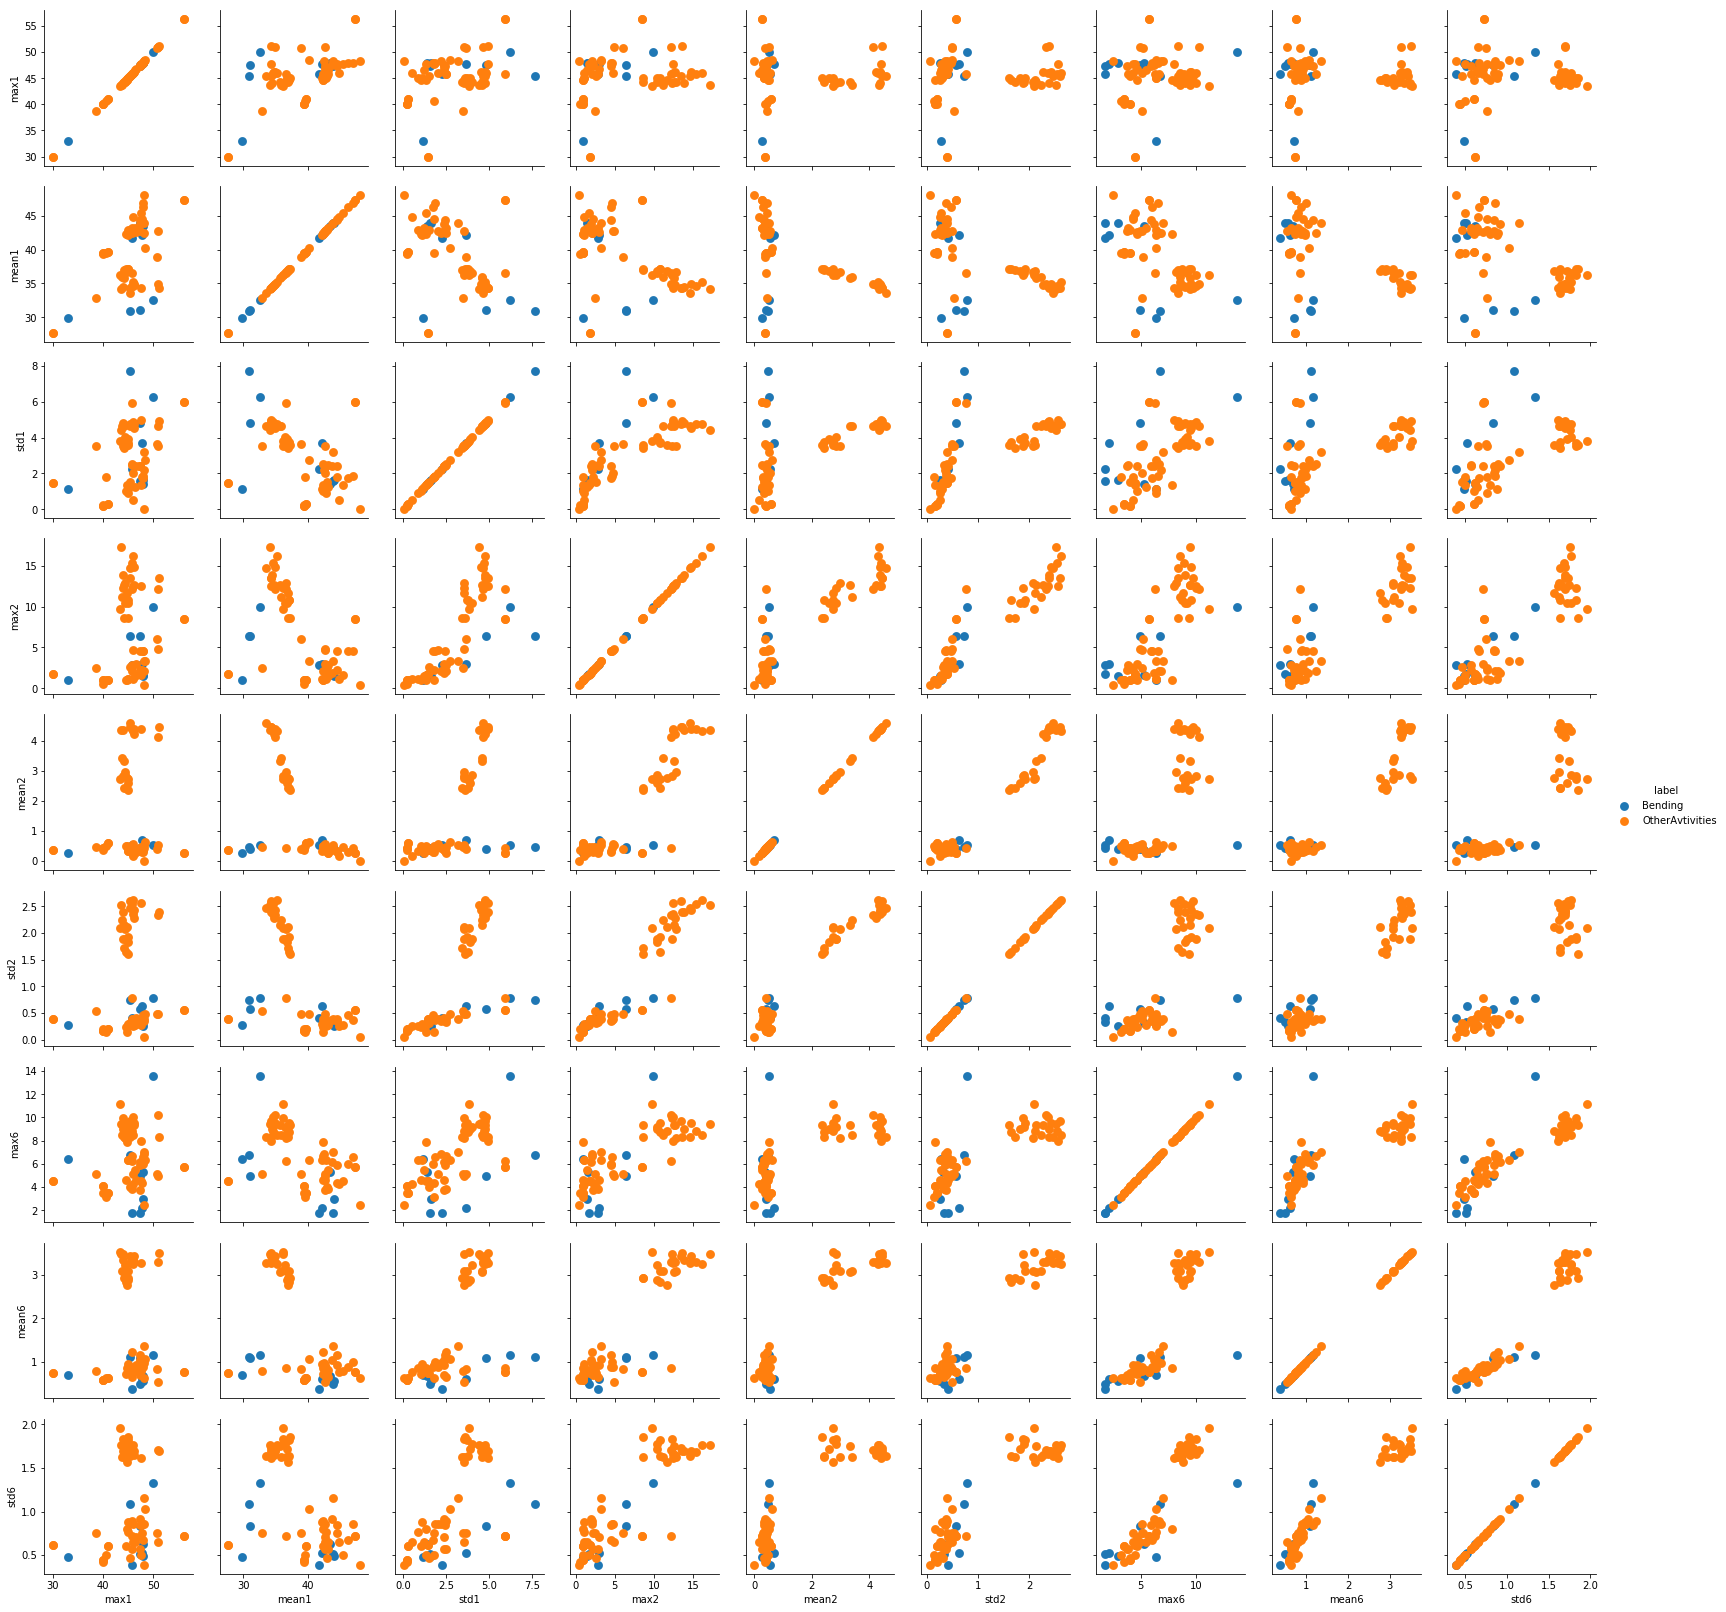

In [18]:
scatter_plot_one(training_set)

### Divide the features further into two parts

In [19]:
def dataset_reset_index(stats):
    stats1 = pd.DataFrame(stats.iloc[0,:]).transpose().reset_index(drop = True)
    stats2 = pd.DataFrame(stats.iloc[1,:]).transpose().reset_index(drop = True)
    stats3 = pd.DataFrame(stats.iloc[2,:]).transpose().reset_index(drop = True)
    stats4 = pd.DataFrame(stats.iloc[3,:]).transpose().reset_index(drop = True)
    stats5 = pd.DataFrame(stats.iloc[4,:]).transpose().reset_index(drop = True)
    stats6 = pd.DataFrame(stats.iloc[5,:]).transpose().reset_index(drop = True)
    
    return stats1, stats2, stats3, stats4, stats5, stats6
    
## Break time series into given number of splits
def break_time_series(filenames, splits):
    final_data = pd.DataFrame()
    for f in filenames:
        data = pd.read_csv(f, skiprows = 4)
        data.drop(columns = ['# Columns: time'], inplace = True)
        features = pd.DataFrame()
        for i in range(0,splits):
            temp = data.iloc[i * len(data)//splits: ((i+1)*len(data)//splits), :]
            stats = temp.describe().transpose().drop(columns = ['count','min','25%','50%','75%'])
            stats = stats.reindex_axis(['max','mean','std'], axis=1)
            
            stats1, stats2, stats3, stats4, stats5, stats6 = dataset_reset_index(stats)
            stats1 = stats1.rename(columns = {'max': 'max1_' + str(i+1),'mean':'mean1_'+ str(i+1),'std' : 'std1_'+ str(i+1)})
            stats2 = stats2.rename(columns = {'max': 'max2_' + str(i+1),'mean':'mean2_' + str(i+1),'std' : 'std2_'+ str(i+1)})
            stats3 = stats3.rename(columns = {'max': 'max3_' + str(i+1),'mean':'mean3_'+ str(i+1),'std' : 'std3_'+ str(i+1)})
            stats4 = stats4.rename(columns = {'max': 'max4_' + str(i+1),'mean':'mean4_'+ str(i+1),'std' : 'std4_'+ str(i+1)})
            stats5 = stats5.rename(columns = {'max': 'max5_' + str(i+1),'mean':'mean5_'+ str(i+1),'std' : 'std5_'+ str(i+1)})
            stats6 = stats6.rename(columns = {'max': 'max6_' + str(i+1),'mean':'mean6_'+ str(i+1),'std' : 'std6_'+ str(i+1)})
            
            stat_append = pd.concat([stats1, stats2, stats3, stats4, stats5, stats6], axis = 1)
            
            features = pd.concat([features,stat_append], axis = 1)
        
        final_data = pd.concat([final_data,features])
    return final_data
    
def scatter_plot_two(training_set):
    ones = pd.DataFrame(np.ones(9), columns = {'label'})
    zeros = pd.DataFrame(np.zeros(60), columns = {'label'})
    label = pd.concat([ones, zeros])
    label = label.replace((1.0,0.0),('Bending','OtherAvtivities'))
    label.index = range(1,70)
    
    complete_features = pd.concat([training_set, label], axis = 1)
    scatter_plot_features = complete_features[['max1_1','mean1_1','std1_1','max2_1','mean2_1','std2_1',
                                               'max6_2','mean6_2','std6_2', 'label']]
    scatter_graph = sns.PairGrid(scatter_plot_features, hue = "label")
    scatter_graph = scatter_graph.map(plt.scatter, linewidth = 5, s = 15, alpha = 1)
    scatter_graph = scatter_graph.add_legend()

In [20]:
split_training_set = break_time_series(training_file_names, 2)
split_training_set.index = range(1,70)

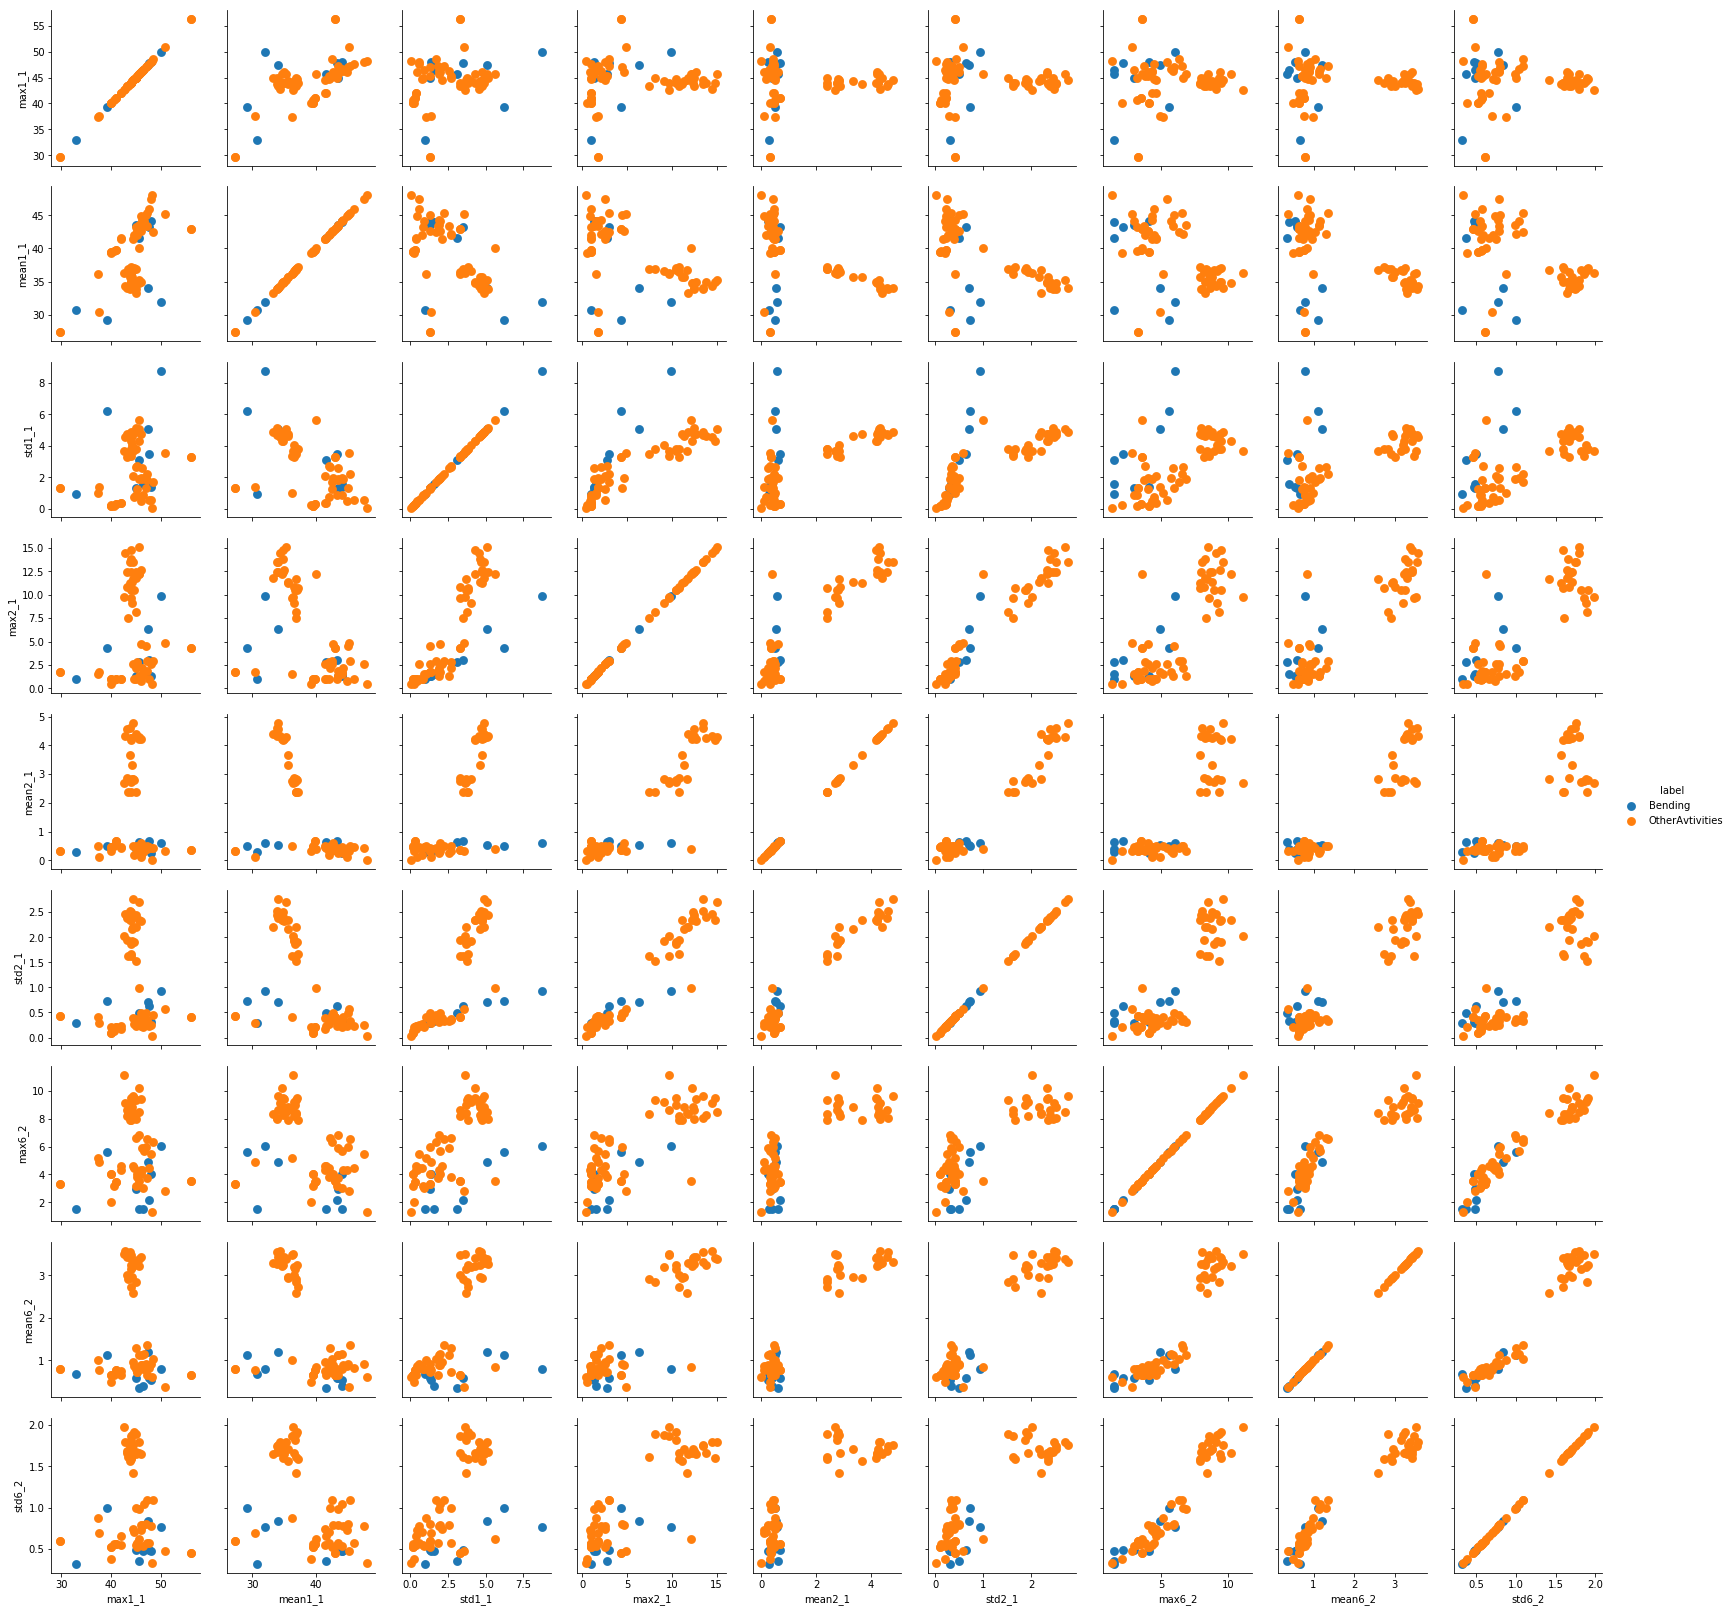

In [21]:
scatter_plot_two(split_training_set)

### There is no considerable difference between results of two plots

### Use recursive feature elimination to select the best set of features

In [22]:
## Generate the classification labels
ones_train = pd.DataFrame(np.ones(9), columns = {'label'})
zeros_train = pd.DataFrame(np.zeros(60), columns = {'label'})
label_train = pd.concat([ones_train, zeros_train])
ones_test = pd.DataFrame(np.ones(4), columns = {'label'})
zeros_test = pd.DataFrame(np.zeros(15), columns = {'label'})
label_test = pd.concat([ones_test, zeros_test])
label_train = label_train.iloc[:,0]
label_test = label_test.iloc[:,0]

In [23]:
def columns_rename(stats_num, num, i):
    stats_num = stats_num.rename(columns = {'max' : 'max'+str(num)+'_' + str(i+1),
                                            'mean':'mean'+str(num)+'_' + str(i+1),
                                            'std' : 'std'+str(num)+'_' + str(i+1)})
    return stats_num
    

def break_time_series(filenames, splits):
    final_data = pd.DataFrame()
    for f in filenames:
        data = pd.read_csv(f, skiprows = 4)
        data.drop(columns = ['# Columns: time'], inplace = True)
        features = pd.DataFrame()
        for i in range(0,splits):
            temp = data.iloc[i * len(data)//splits: ((i+1)*len(data)//splits), :]
            stats = temp.describe().transpose().drop(columns = ['count','min','25%','50%','75%',])
            stats = stats.reindex(['max','mean','std'], axis=1)
            
            stats1, stats2, stats3, stats4, stats5, stats6 = dataset_reset_index(stats)
            
            stats1 = columns_rename(stats1, 1, i)
            stats2 = columns_rename(stats2, 2, i)
            stats3 = columns_rename(stats3, 3, i)
            stats4 = columns_rename(stats4, 4, i)
            stats5 = columns_rename(stats5, 5, i)
            stats6 = columns_rename(stats6, 6, i)
            
            stat_append = pd.concat([stats1, stats2, stats3, stats4, stats5, stats6], axis = 1)
            
            features = pd.concat([features,stat_append], axis = 1)
        
        final_data = pd.concat([final_data,features])
    return final_data

In [24]:
## Normalize train and test data
def normalize_features_train(train_filenames, l):
    training_data = break_time_series(train_filenames, l)
    minmax = MinMaxScaler()
    normalized_training_data = minmax.fit_transform(training_data)
    normalized_training_data = pd.DataFrame(normalized_training_data, columns = training_data.columns)
    return normalized_training_data

def normalize_features_test(train_filenames, test_filenames, l):
    training_data = break_time_series(train_filenames, l)
    test_data = break_time_series(test_filenames,l)
    minmax = MinMaxScaler()
    normalized_training_data = minmax.fit_transform(training_data)
    normalized_test_data = minmax.transform(test_data)
    normalized_test_data = pd.DataFrame(normalized_test_data, columns = test_data.columns)
    
    return normalized_test_data

## Find best values of split and number of features using cross-validation
def best_split_features(train_filenames, label_train):
    label_train = label_train.values.ravel()
    split = 0
    features = 0
    final_score = 0
    for l in range(1,21):
        training_data = normalize_features_train(train_filenames, l)

        lr = LogisticRegression(C = sys.maxsize, solver = 'liblinear')
        skf = StratifiedKFold(n_splits = 5)
        print('Current splits >>>>>>> ', l)
        for p in range(5, len(training_data.columns)):
            
            rfe = RFE(lr, n_features_to_select = p)
            rfe = rfe.fit(training_data, label_train)
            
            score = cross_val_score(rfe, training_data, label_train, cv = 5)
            score = score.mean()
            if(score > final_score):
                final_score = score
                features = p
                split = l
            
        print('best score of the split:', final_score)
        print()
            
    print('final best score:', final_score)
    return split, features

In [25]:
split, features = best_split_features(training_file_names, label_train)

Current splits >>>>>>>  1
best score of the split: 0.9571428571428571

Current splits >>>>>>>  2
best score of the split: 0.9714285714285715

Current splits >>>>>>>  3
best score of the split: 0.9714285714285715

Current splits >>>>>>>  4
best score of the split: 0.9714285714285715

Current splits >>>>>>>  5
best score of the split: 0.9714285714285715

Current splits >>>>>>>  6
best score of the split: 0.9714285714285715

Current splits >>>>>>>  7
best score of the split: 0.9714285714285715

Current splits >>>>>>>  8
best score of the split: 0.9714285714285715

Current splits >>>>>>>  9
best score of the split: 0.9714285714285715

Current splits >>>>>>>  10
best score of the split: 0.9714285714285715

Current splits >>>>>>>  11
best score of the split: 0.9714285714285715

Current splits >>>>>>>  12
best score of the split: 0.9714285714285715

Current splits >>>>>>>  13
best score of the split: 0.9714285714285715

Current splits >>>>>>>  14
best score of the split: 0.9714285714285715

C

### Best (l,p) pair

In [26]:
print("Best split value 'l' =", split)
print("Best feature value 'p' =", features)

Best split value 'l' = 2
Best feature value 'p' = 12


In [27]:
## Results of using cross-validated classifier on train and test data
def cross_validation_results(training_file_names, test_file_names, label_train, label_test, split, features):
    data_train = normalize_features_train(training_file_names, split)
    data_test = normalize_features_test(training_file_names, test_file_names, split)
    lr = LogisticRegression(C = sys.maxsize, solver = 'liblinear')
    rfe = RFE(lr, n_features_to_select = features)
    rfe = rfe.fit(data_train, label_train)
    print('Accuracy on training data:', rfe.score(data_train, label_train))
    

In [28]:
cross_validation_results(training_file_names, test_file_names, label_train, label_test, split, features)

Accuracy on training data: 1.0


## Wrong way to use cross-validation:
We are asked to use a 5-fold cross-validation to find best (l,p) pair. That is, we need to cross-validate on a (l,p) pair to find the best score. A wrong way of doing cross-validation would be to first fix a particular 'l', and then use cross-validation to find the best value of 'p', or vice-versa.

## Correct way to use cross-validation:
Use a nested for loop to generate all possible combinations of (l,p) pairs. Use cross-validation on all the (l,p) pairs to find the best mean score from all the folds.

### Plot the correlation matrix and AUC

In [29]:
## Function to plot the confusion matrix
## Reference: Sckit learn confusion matrix library
def plot_confusion_matrix(cm, classes, title = 'confusion matrix', cmap=plt.cm.Blues, normalize = False):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Function to plot ROC AUC curve
def roc_auc_curve(rfe, training_data, train_label):
    predicted_values = rfe.predict(training_data)
    cm = confusion_matrix(train_label, predicted_values)
    fpr, tpr , threshold = roc_curve(label_train, predicted_values)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    classes = ['bending', 'other']
    
    return cm, classes

def logistic_regression_model(training_data, train_label,features):
    lr = LogisticRegression(C = sys.maxsize, solver = 'liblinear')
    rfe = RFE(lr, n_features_to_select = features)
    rfe = rfe.fit(training_data, train_label)
    return rfe
    

    

## ROC AUC for train data

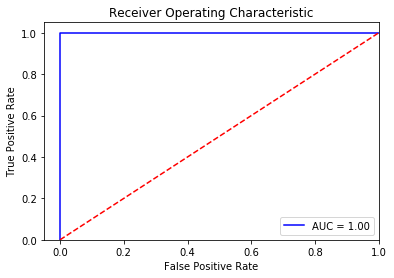

In [30]:
roc_auc_training_data = normalize_features_train(training_file_names, split)
rfe = logistic_regression_model(roc_auc_training_data, label_train, features)
cm, classes = roc_auc_curve(rfe, roc_auc_training_data, label_train )

## Confusion Matrix

Confusion matrix for train data


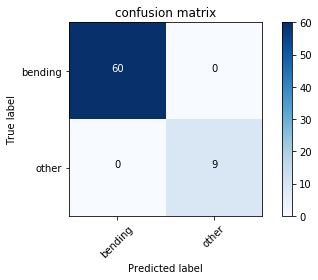

In [31]:
print('Confusion matrix for train data')
plot_confusion_matrix(cm, classes)

### Coefficients Logistic Regression Parameters

In [32]:
def logistic_regression_parameters(rfe, training_data, label_train):
    train_new_data = rfe.transform(training_data)
    lr = LogisticRegression(C = sys.maxsize, solver = 'liblinear')
    lr.fit(train_new_data, label_train)
    train_new_data = pd.DataFrame(train_new_data)
    
    columns = []
    for i in range (len(rfe.ranking_)):
        if (rfe.ranking_[i] == 1):
            columns.append(training_data.columns[i])
    
    
    for i in range (len(columns)):
        print("Coeff of",columns[i],"=", np.round(lr.coef_[0][i],4))
        
    return lr, train_new_data, columns

In [33]:
lr, train_new_data, columns = logistic_regression_parameters(rfe, roc_auc_training_data, label_train)

Coeff of mean1_1 = -19.5054
Coeff of std1_1 = 15.3647
Coeff of max2_1 = -23.1698
Coeff of max3_1 = 9.173
Coeff of std3_1 = 15.9789
Coeff of max5_1 = 31.1447
Coeff of mean5_1 = 20.0689
Coeff of std3_2 = -13.7037
Coeff of max5_2 = 15.7146
Coeff of std5_2 = -22.1431
Coeff of max6_2 = -14.0982
Coeff of std6_2 = -13.2251


### Calculating p-values

In [34]:
def fit(lr, train_new_data,label_train):
        lr = lr.fit(train_new_data,label_train)
    
        denomirator = (2.0*(1.0+np.cosh(lr.decision_function(train_new_data))))
        denomirator = np.tile(denomirator,(train_new_data.shape[1],1)).T
        ## Fisher Information Matrix
        F_ij = np.dot((train_new_data/denomirator).T,train_new_data)
        ## Inverse Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        # z-score for eaach model coefficient
        z_scores = lr.coef_[0]/sigma_estimates
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores]
        
        return sigma_estimates, p_values, z_scores
##References used: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

In [35]:
sigma_estimates, p_values,z_scores = fit(lr, train_new_data,label_train)

In [36]:
coef_p_values = pd.DataFrame(columns = ['Features','standard_Error','z_scores','p_values'])
coef_p_values.Features = columns
coef_p_values.standard_Error = sigma_estimates
coef_p_values.z_scores = z_scores
coef_p_values.p_values = p_values

In [37]:
coef_p_values

,Features,standard_Error,z_scores,p_values
0,mean1_1,674.890908,-0.028902,0.976943
1,std1_1,1770.431194,0.008679,0.993076
2,max2_1,3184.583973,-0.007276,0.994195
3,max3_1,919.761840,0.009973,0.992043
4,std3_1,3858.683140,0.004141,0.996696
5,max5_1,2927.969128,0.010637,0.991513
6,mean5_1,5258.889121,0.003816,0.996955
7,std3_2,3580.828847,-0.003827,0.996947
8,max5_2,2250.505697,0.006983,0.994429
9,std5_2,3371.179020,-0.006568,0.994759


### Test the selected classifier on the test dataset

In [38]:
def test_classifier(rfe, lr, test_data, label_test):
    test_data = rfe.transform(test_data)
    accuracy = lr.score(test_data, label_test)
    
    return accuracy

In [39]:
test_data = normalize_features_test(training_file_names, test_file_names, split)

#### Accuracy of the test set

In [40]:
accuracy = test_classifier(rfe, lr, test_data, label_test)
print('The accuracy of test set is:', accuracy)

The accuracy of test set is: 0.9473684210526315


### The accuracy of the cross-validation set is 0.971, whereas the accuracy of the test set is 0.9473

### The classes are well-seperated. This is evident by the fact that we get a train accuracy equal to 1.0 for almost all combination of feautres and splits. It causes instability in calculating logistic regression parameters. Even the 'statsmodel' API throws up an error like 'Perfect seperation detected, results not available'.

### From the confusion matrix, we can clearly see a class imbalance. The class with label 0 contains 60 samples, whereas the class with label 1 contains 9 samples. Due to this imbalance in the data, I have used an oversampling technique called as Synthetic Minority Oversampling (SMOTE), which is an algorithm that synthetically generates samples for the minority class.

### Use synthetic minority oversampling to upsample the minority class

In [41]:
## Use synthetic minority oversampling
def data_oversampling(filenames, splits, label_train):
    training_data = break_time_series(filenames, splits)
    sm = SMOTE(random_state = 42)
    data_new, label_new = sm.fit_resample(training_data, label_train)
    data_new = pd.DataFrame(data_new, columns = training_data.columns)
    
    return data_new, label_new

In [42]:
def oversampling_best_split_features(train_filenames, label_train):
    label_train = label_train.values.ravel()
    split = 0
    features = 0
    final_score = 0
    for l in range(1,21):
        training_data, label_new = data_oversampling(train_filenames, l, label_train)
        lr = LogisticRegression(C = sys.maxsize, solver = 'liblinear')
        skf = StratifiedKFold(n_splits = 5)
        print('Current splits >>>>>>> ', l)
        for p in range(5, len(training_data.columns)):
            
            rfe = RFE(lr, n_features_to_select = p)
            rfe = rfe.fit(training_data, label_new)
            
            score = cross_val_score(rfe, training_data, label_new, cv = 5)
            score = score.mean()
            if(score > final_score):
                final_score = score
                features = p
                split = l
            
        print('best score of the split:', final_score)
        print()
            
    print('final best score:', final_score)
    return split, features

In [43]:
sampling_split, sampling_features = oversampling_best_split_features(training_file_names, label_train)

Current splits >>>>>>>  1
best score of the split: 0.9583333333333333

Current splits >>>>>>>  2
best score of the split: 0.9583333333333333

Current splits >>>>>>>  3
best score of the split: 0.9916666666666668

Current splits >>>>>>>  4
best score of the split: 0.9916666666666668

Current splits >>>>>>>  5
best score of the split: 0.9916666666666668

Current splits >>>>>>>  6
best score of the split: 0.9916666666666668

Current splits >>>>>>>  7
best score of the split: 0.9916666666666668

Current splits >>>>>>>  8
best score of the split: 0.9916666666666668

Current splits >>>>>>>  9
best score of the split: 0.9916666666666668

Current splits >>>>>>>  10
best score of the split: 0.9916666666666668

Current splits >>>>>>>  11
best score of the split: 0.9916666666666668

Current splits >>>>>>>  12
best score of the split: 1.0

Current splits >>>>>>>  13
best score of the split: 1.0

Current splits >>>>>>>  14
best score of the split: 1.0

Current splits >>>>>>>  15
best score of the s

### Best (l,p) split after using case-control sampling

In [44]:
print('Best value for split:', sampling_split)
print('Optimal number of features:', sampling_features)

Best value for split: 12
Optimal number of features: 5


### ROC AUC for test data

In [45]:
def roc_auc_curve_oversampled(label_test, predicted_values):
    cm = confusion_matrix(label_test, predicted_values)
    fpr, tpr , threshold = roc_curve(label_test, predicted_values)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    classes = ['bending','other']
    
    return cm, classes

def logistic_regression_model_oversampled(training_data, train_label,features):
    training_data, label_new = data_oversampling(train_filenames, l, label_train)
    lr = LogisticRegression(C = sys.maxsize, solver = 'liblinear')
    rfe = RFE(lr, n_features_to_select = features)
    rfe = rfe.fit(training_data, train_label)
    return rfe

In [46]:
oversampled_train_data, label_oversampled = data_oversampling(training_file_names, sampling_split, label_train)
temp_test_data = break_time_series(test_file_names, sampling_split)

In [47]:
oversampled_train_data.shape

(120, 216)

In [48]:
lr_oversampled = LogisticRegression(C = sys.maxsize, solver = 'liblinear')
rfe_oversampled = RFE(lr_oversampled, n_features_to_select = sampling_features)
rfe_oversampled.fit(oversampled_train_data, label_oversampled)
predicted_values = rfe_oversampled.predict(temp_test_data)

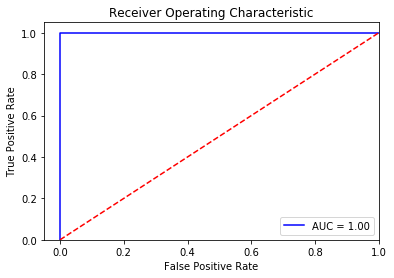

In [49]:
## ROC for the test data
cm_oversampled, classes_oversampled = roc_auc_curve_oversampled(label_test, predicted_values)

### Confusion matrix for train data

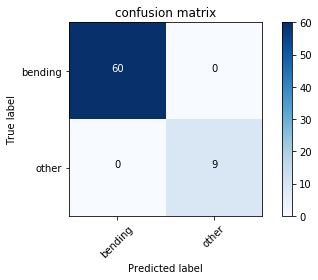

In [50]:
plot_confusion_matrix(cm, classes)

### Confusion matrix for the test data

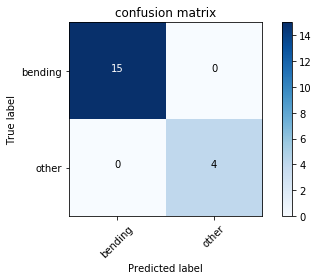

In [51]:
plot_confusion_matrix(cm_oversampled, classes_oversampled)

In [52]:
print('Training score for RFE with case control sampling:', rfe_oversampled.score(oversampled_train_data, label_oversampled))
print('Test score for RFE with case control sampling:', rfe_oversampled.score(temp_test_data, label_test))

Training score for RFE with case control sampling: 1.0
Test score for RFE with case control sampling: 1.0


### Repeat the above steps using L1 penalized Logistic regression

In [53]:
## L1 penalized logistic regression
def best_split_features_l1(train_filenames, label_train, s):
    label_train = label_train.values.ravel()
    split = 0
    c_value = 0
    final_score = 0
    c_range = [0.001,0.005, 0.01, 0.05, 0.1, 0.5, 1, 5,10,100]
    for l in range(1,21):
        training_data = normalize_features_train(train_filenames, l)

        skf = StratifiedKFold(n_splits = 5)
        print('Current splits >>>>>>> ', l)
        for c in c_range:
            lr = LogisticRegression(penalty = 'l1' , C = c, solver = s)
            
            score = cross_val_score(lr, training_data, label_train, cv = skf)
            score = score.mean()
            
            if(score > final_score):
                final_score = score
                c_value = c
                split = l
            
        print('best score of the split:', final_score)
        print()
            
    print('final best score:', final_score)
    return split, c_value

In [54]:
l1_split, c_value = best_split_features_l1(training_file_names, label_train, 'liblinear')

Current splits >>>>>>>  1
best score of the split: 0.9857142857142858

Current splits >>>>>>>  2
best score of the split: 0.9857142857142858

Current splits >>>>>>>  3
best score of the split: 0.9857142857142858

Current splits >>>>>>>  4
best score of the split: 0.9857142857142858

Current splits >>>>>>>  5
best score of the split: 0.9857142857142858

Current splits >>>>>>>  6
best score of the split: 0.9857142857142858

Current splits >>>>>>>  7
best score of the split: 0.9857142857142858

Current splits >>>>>>>  8
best score of the split: 0.9857142857142858

Current splits >>>>>>>  9
best score of the split: 0.9857142857142858

Current splits >>>>>>>  10
best score of the split: 0.9857142857142858

Current splits >>>>>>>  11
best score of the split: 0.9857142857142858

Current splits >>>>>>>  12
best score of the split: 0.9857142857142858

Current splits >>>>>>>  13
best score of the split: 0.9857142857142858

Current splits >>>>>>>  14
best score of the split: 0.9857142857142858

C

### Best (l, c) pair for l1 regularized model

In [55]:
print('Best value of l1 regularized data split:', l1_split)
print('Optimal value of inverse of regularization constant:' ,c_value)

Best value of l1 regularized data split: 1
Optimal value of inverse of regularization constant: 5


In [56]:
training_data_l1 = normalize_features_train(training_file_names, l1_split)
test_data_l1 = normalize_features_test(training_file_names, test_file_names, l1_split)
lr_regularized = LogisticRegression(penalty = 'l1' , C = c_value, solver = 'liblinear')
lr_regularized = lr.fit(training_data_l1, label_train)
print('Training score of the l1 regualrized model:', lr_regularized.score(training_data_l1, label_train))
print('Test score of the l1 regularized model:', lr_regularized.score(test_data_l1, label_test))

Training score of the l1 regualrized model: 1.0
Test score of the l1 regularized model: 1.0


### The L1 regularized model gave a train and test score of 1.0, whereas the Variable selection using p-values gave us a train score of 1.0 and a test score of 0.94. Thus, according to our observations, L1 regularized model performs better compared to Variable selection. 

### L1 regularization is easier to implement as it implicitly does the feature selection. Also, according to ( ref: https://icml.cc/Conferences/2004/proceedings/papers/354.pdf by Andrew Ng), it has been shown that L1 regularized logistic regression is effective even if there are exponentially many irrelevant features compared to training examples in the dataset.

### Multiclass classification using Logistic Regression

In [57]:
## Generating multiclass labels
def multiclass_label(string):
    multiclass_label = []
    for name in glob.glob('ActivityDataset/' + string + '/b1*'):
        multiclass_label.append(0)
    for name in glob.glob('ActivityDataset/' +string + '/b2*'):
        multiclass_label.append(1)
    for name in glob.glob('ActivityDataset/' +string + '/c*'):
        multiclass_label.append(2)
    for name in glob.glob('ActivityDataset/' +string + '/l*'):
        multiclass_label.append(3)
    for name in glob.glob('ActivityDataset/' +string + '/si*'):
        multiclass_label.append(4)
    for name in glob.glob('ActivityDataset/' +string + '/st*'):
        multiclass_label.append(5)
    for name in glob.glob('ActivityDataset/' +string + '/w*'):
        multiclass_label.append(6)
        
    return multiclass_label

In [58]:
label_multiclass_train = multiclass_label('activity_train_data')
label_multiclass_test = multiclass_label('activity_test_data')

In [59]:
label_multiclass_train = pd.Series(label_multiclass_train)

In [60]:
multiclass_split, multiclass_c_value = best_split_features_l1(training_file_names, label_multiclass_train,
                                                              'saga')

Current splits >>>>>>>  1
best score of the split: 0.8798573975044561

Current splits >>>>>>>  2
best score of the split: 0.8931372549019608

Current splits >>>>>>>  3
best score of the split: 0.8931372549019608

Current splits >>>>>>>  4
best score of the split: 0.8931372549019608

Current splits >>>>>>>  5
best score of the split: 0.8931372549019608

Current splits >>>>>>>  6
best score of the split: 0.8931372549019608

Current splits >>>>>>>  7
best score of the split: 0.8931372549019608

Current splits >>>>>>>  8
best score of the split: 0.8931372549019608

Current splits >>>>>>>  9
best score of the split: 0.8931372549019608

Current splits >>>>>>>  10
best score of the split: 0.8931372549019608

Current splits >>>>>>>  11
best score of the split: 0.8931372549019608

Current splits >>>>>>>  12
best score of the split: 0.8931372549019608

Current splits >>>>>>>  13
best score of the split: 0.8931372549019608

Current splits >>>>>>>  14
best score of the split: 0.8931372549019608

C

### Optimal value of (l, c) pair for multiclass classification using l1 regularization

In [61]:
print('Best value of no. of splits for multi-class classification:', multiclass_split)
print('Optimal value for inverse of regularization constant:', multiclass_c_value)

Best value of no. of splits for multi-class classification: 2
Optimal value for inverse of regularization constant: 100


### Train and test error 

In [62]:
lr_multiclass = LogisticRegression(penalty = 'l1', C = multiclass_c_value, solver = 'saga')
lr_multiclass = lr_multiclass.fit(training_data_l1, label_multiclass_train)
train_error = 1 - lr_multiclass.score(training_data_l1, label_multiclass_train)
test_error = 1 - lr_multiclass.score(test_data_l1, label_multiclass_test)
predicted_train_value = lr_multiclass.predict(training_data_l1)
predicted_test_value = lr_multiclass.predict(test_data_l1)
print('Training error of the l1 regualrized multi-class model:', train_error)
print('Test error of the l1 regularized multi-class model:', test_error)

Training error of the l1 regualrized multi-class model: 0.02898550724637683
Test error of the l1 regularized multi-class model: 0.10526315789473684


### Test error for l1 penalized multinomial model: 0.105

In [63]:
label_multiclass_test

[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]

In [64]:
predicted_test_value

array([0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 3, 5, 5, 6, 6, 6])

In [65]:
classes=['bending1','bending2','cycling','lying','sitting','standing','walking']

In [66]:
def plot_multiclass_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Confusion matrix for multi-class classification using l1 regularization

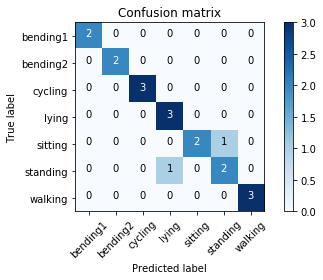

In [67]:
multiclass_cnf = confusion_matrix(label_multiclass_test, predicted_test_value, labels=[0,1,2,3,4,5,6])
plot_multiclass_confusion_matrix(multiclass_cnf, classes)

## ROC AUC for multiclass classification using l1 regularization


### ROC for multiclass classification is approximated using a pairwise approach, that approximates the multidimensional ROC by discounting some interactions. This results in an algorithm that is tractable and extensible to a large number of classes. Although, any 2-D representation of Multiclass ROC is just an approximation, and should not be taken as a real representation of ROC.
Reference: http://dmip.webs.upv.es/ROCML2005/papers/fieldsend2CRC.pdf

In [73]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp

In [74]:
def roc_multiclass_approximation(y, y_pred):
    y = label_binarize(y, classes=[0,1,2,3,4,5,6])
    y_pred = label_binarize(y_pred, classes = [0,1,2,3,4,5,6])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Approximate Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

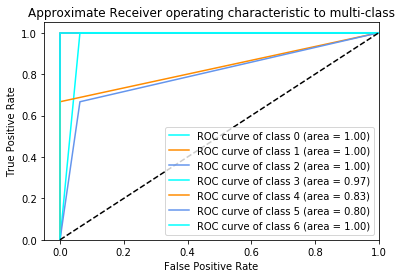

In [75]:
roc_multiclass_approximation(label_multiclass_test, predicted_test_value)
## Reference: Sckit learn ROC AUC library

### Multiclass classification using Gaussian Naive Bayes Classifier

In [76]:
## Function for Gaussian Naive Bayes
def Gaussian_NB(train_filenames, label_train):
    label_train = label_train.values.ravel()
    split = 0
    var_smoothing = 0
    final_score = 0
    var_range = [1e-11, 1e-10, 1e-09, 1e-08, 1e-07]
    for l in range(1,21):
        training_data = normalize_features_train(train_filenames, l)
        skf = StratifiedKFold(n_splits = 5)
        print('Current splits >>>>>>> ', l)
        for var in var_range:
            gnb = GaussianNB(var_smoothing = var)
            
            score = cross_val_score(gnb, training_data, label_train, cv = skf)
            score = score.mean()
            
            if(score > final_score):
                final_score = score
                var_smoothing = var
                split = l
            
        print('best score of the split:', final_score)
        print()
            
    print('final best score:', final_score)
    return split, var_smoothing

In [77]:
gaussian_split, var = Gaussian_NB(training_file_names, label_multiclass_train)

Current splits >>>>>>>  1
best score of the split: 0.896524064171123

Current splits >>>>>>>  2
best score of the split: 0.896524064171123

Current splits >>>>>>>  3
best score of the split: 0.896524064171123

Current splits >>>>>>>  4
best score of the split: 0.896524064171123

Current splits >>>>>>>  5
best score of the split: 0.896524064171123

Current splits >>>>>>>  6
best score of the split: 0.896524064171123

Current splits >>>>>>>  7
best score of the split: 0.896524064171123

Current splits >>>>>>>  8
best score of the split: 0.896524064171123

Current splits >>>>>>>  9
best score of the split: 0.896524064171123

Current splits >>>>>>>  10
best score of the split: 0.896524064171123

Current splits >>>>>>>  11
best score of the split: 0.896524064171123

Current splits >>>>>>>  12
best score of the split: 0.896524064171123

Current splits >>>>>>>  13
best score of the split: 0.896524064171123

Current splits >>>>>>>  14
best score of the split: 0.896524064171123

Current splits 

### Optimal value of splits for Gaussian NB

In [78]:
print('Best value of split for Gaussian NB:', gaussian_split)
print('Optimal value of variance smoothing:', var)

Best value of split for Gaussian NB: 1
Optimal value of variance smoothing: 1e-11


### Train and test error for Gaussian NB

In [79]:
gnb_multiclass = GaussianNB(var_smoothing = var)
training_data_gnb = normalize_features_train(training_file_names, gaussian_split)
test_data_gnb = normalize_features_train(test_file_names, gaussian_split)
gnb_multiclass = gnb_multiclass.fit(training_data_gnb, label_multiclass_train)
gnb_train_error = 1 - gnb_multiclass.score(training_data_gnb, label_multiclass_train)
gnb_test_error = 1 - gnb_multiclass.score(test_data_gnb, label_multiclass_test)
gnb_predicted_train_value = gnb_multiclass.predict(training_data_gnb)
gnb_predicted_test_value = gnb_multiclass.predict(test_data_gnb)
print('Training error of the Gaussian NB multi-class model:', gnb_train_error)
print('Test error of the Gaussian NB multi-class model:', gnb_test_error)

Training error of the Gaussian NB multi-class model: 0.02898550724637683
Test error of the Gaussian NB multi-class model: 0.1578947368421053


### Confusion matrix for Gaussian Naive Bayes

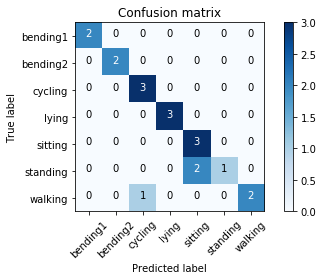

In [80]:
multiclass_gnb = confusion_matrix(label_multiclass_test, gnb_predicted_test_value, labels=[0,1,2,3,4,5,6])
plot_multiclass_confusion_matrix(multiclass_gnb, classes)

### ROC AUC for Gaussian NB

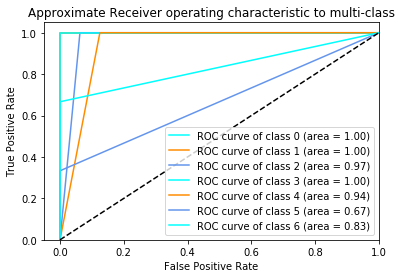

In [81]:
roc_multiclass_approximation(label_multiclass_test, gnb_predicted_test_value)

### Multiclass classification using multinomial naive bayes

In [82]:
## Function for Multinomial Naive Bayes
def Multinomial_NB(train_filenames, label_train):
    label_train = label_train.values.ravel()
    split = 0
    alpha = 0
    final_score = 0
    alpha_range = [0.2, 0.5, 0.7, 1, 1.2, 1.5, 2,5,10]
    for l in range(1,20):
        training_data = normalize_features_train(train_filenames, l)
        skf = StratifiedKFold(n_splits = 5)
        print('Current splits >>>>>>> ', l)
        for alpha_val in alpha_range:
            mnb = MultinomialNB(alpha = alpha_val)
            
            score = cross_val_score(mnb, training_data, label_train, cv = skf)
            score = score.mean()
            
            if(score > final_score):
                final_score = score
                alpha = alpha_val
                split = l
            
        print('best score of the split:', final_score)
        print()
            
    print('final best score:', final_score)
    return split, alpha

In [83]:
multinomial_split, alpha = Multinomial_NB(training_file_names, label_multiclass_train)

Current splits >>>>>>>  1
best score of the split: 0.7513368983957219

Current splits >>>>>>>  2
best score of the split: 0.8229946524064171

Current splits >>>>>>>  3
best score of the split: 0.8229946524064171

Current splits >>>>>>>  4
best score of the split: 0.8229946524064171

Current splits >>>>>>>  5
best score of the split: 0.8278966131907308

Current splits >>>>>>>  6
best score of the split: 0.83475935828877

Current splits >>>>>>>  7
best score of the split: 0.8514260249554366

Current splits >>>>>>>  8
best score of the split: 0.8514260249554366

Current splits >>>>>>>  9
best score of the split: 0.8529411764705882

Current splits >>>>>>>  10
best score of the split: 0.8529411764705882

Current splits >>>>>>>  11
best score of the split: 0.8529411764705882

Current splits >>>>>>>  12
best score of the split: 0.8529411764705882

Current splits >>>>>>>  13
best score of the split: 0.8529411764705882

Current splits >>>>>>>  14
best score of the split: 0.8529411764705882

Cur

### Optimal value of split for multinomial NB

In [84]:
print('Best value of split for Multinomial NB:',multinomial_split )
print('Optimal value of additive smoothing:', alpha)

Best value of split for Multinomial NB: 9
Optimal value of additive smoothing: 0.2


### Train and test error for multinomial NB

In [85]:
mnb_multiclass = MultinomialNB(alpha = alpha)
training_data_mnb = normalize_features_train(training_file_names, multinomial_split)
test_data_mnb = normalize_features_train(test_file_names, multinomial_split)
mnb_multiclass = mnb_multiclass.fit(training_data_mnb, label_multiclass_train)
mnb_train_error = 1 - mnb_multiclass.score(training_data_mnb, label_multiclass_train)
mnb_test_error = 1 - mnb_multiclass.score(test_data_mnb, label_multiclass_test)
mnb_predicted_train_value = mnb_multiclass.predict(training_data_mnb)
mnb_predicted_test_value = mnb_multiclass.predict(test_data_mnb)
print('Training error of the Multinomial NB multi-class model:', mnb_train_error)
print('Test error of the Multinomial NB multi-class model:', mnb_test_error)

Training error of the Multinomial NB multi-class model: 0.08695652173913049
Test error of the Multinomial NB multi-class model: 0.21052631578947367


### Confusion matrix for multinomial NB

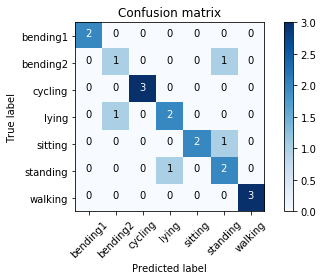

In [86]:
multiclass_mnb = confusion_matrix(label_multiclass_test, mnb_predicted_test_value, labels=[0,1,2,3,4,5,6])
plot_multiclass_confusion_matrix(multiclass_mnb, classes)

### ROC AUC for multinomial NB

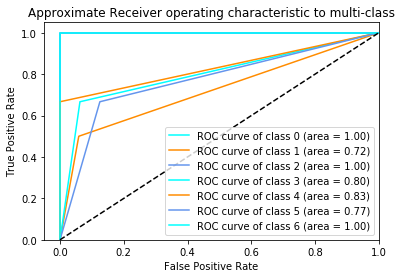

In [87]:
roc_multiclass_approximation(label_multiclass_test, mnb_predicted_test_value)

Test error for l1 penalized multiclass model: 0.105

Test error for Gaussian Naive Bayes: 0.157

Test error for Multinomial Naive Bayes: 0.210

### Thus, according to our observations, the l1 penalized logistic regression performs better than the other two models for multiclass classification.